# Data Preprocessing and Library loading:

In [1]:
import json, sys, time, os, copy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas
import pickle

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_curve, roc_auc_score

plt.rcParams['figure.figsize'] = [6.4*2, 4.8*2]
sns.set_theme("paper")
sns.set_style(style="darkgrid")
fullDataset = False

In [2]:
jsonDir = "./jsonFiles"
numpyDir = "./numpyFiles"

fullTestSet = np.load(os.path.join(numpyDir,"fullTestSet.npy"))
errMSE = np.load(os.path.join(numpyDir,"ERROR_MAE_3D_T1.npy"))

with open(os.path.join(jsonDir,"file_list_3D_MAE.json"),"r") as f:
    fileList = json.load(f)

fileList = [x[:-8] for x in fileList]

print("Number of Files: ", len(fileList))

Number of Files:  31199


In [3]:
# Flattening Error volume 8x7x7 for RF
import itertools

knNums = list(itertools.combinations_with_replacement([0,1,2,3,4,5,6],2))
errFlat = np.zeros((errMSE.shape[0],errMSE.shape[1]*len(knNums)))

for i in range(errMSE.shape[0]):
    cnt = 0
    for j in range(errMSE.shape[1]):
        for kn0,kn1 in knNums:
            errFlat[i,cnt] = errMSE[i,j,kn0,kn1]
            cnt += 1

print("Pre Flatten {} vs. Flattened {}".format(errMSE.shape,errFlat.shape))

Pre Flatten (31199, 8, 7, 7) vs. Flattened (31199, 224)


In [4]:
# Load in tags and additional meta data:

with open(os.path.join(jsonDir,"./reasons_split.json"),"r") as f: # Tags
    tagDict = json.load(f)

if not fullDataset:
    with open(os.path.join(jsonDir,"biobank_meta_float.json"),"r") as f: # Float meta data from dcm headers
        metaDict = json.load(f)
else:
    with open(os.path.join(jsonDir,"biobank_meta_full_one_hot.json"),"r") as f: # All one hot encoded meta
        metaDict = json.load(f)

with open(os.path.join(jsonDir,"Biobank_Bounding_Boxes.json"),"r") as f: # Bounding box meta data
    bBoxes = json.load(f)

In [10]:
patKey = list(metaDict.keys())[0]
metaDict[patKey].keys()

dict_keys(['1', '2', '3', '4', '5', '6', '7'])

In [5]:
# Sort through subj to make sure all meta data present

if fullDataset:
    keys = list(metaDict['eid'].values())
else:
    keys = list(metaDict.keys())

keys = [k for k in keys if k in bBoxes.keys()]
keys = [k for k in keys if k in fileList]

print("Number of Files with complete meta data: ", len(keys))

Number of Files with complete meta data:  31199


In [6]:
###### Find out the keys present in every single case:
if not fullDataset:
    allMetaKeys = []
    instTime = ["1","2","3","4","5","6","7"]
    for k in keys:
        for i in instTime:
            allMetaKeys.extend(list(metaDict[k][i].keys()))

    allMetaKeysSet = set(allMetaKeys)

    keysOI = []
    for k in allMetaKeysSet:
        if allMetaKeys.count(k) == (len(keys)*7):
            keysOI.append(k)
else:
    keysOI = list(metaDict.keys())

print("Meta values to use: \n\n", keysOI)

Meta values to use: 

 ['Number of Averages', 'Echo Train Length', '[CSA Image Header Version ??]', "Patient's Weight", 'Rows', 'Instance Number', 'Slice Thickness', 'Device Serial Number', 'Flip Angle', 'Samples per Pixel', 'Percent Phase Field of View', 'Columns', 'Study Time', 'Bits Stored', '[RealDwellTime]', 'Content Date', 'Series Number', 'Bits Allocated', 'Echo Number(s)', '[CSA Series Header Version]', 'Echo Time', 'Pixel Representation', 'Window Width', 'Imaging Frequency', 'Series Date', 'Percent Sampling', '[SliceMeasurementDuration]', 'Acquisition Time', 'Window Center', 'Repetition Time', 'Study Date', 'Content Time', 'Number of Phase Encoding Steps', '[CSA Image Header Version]', 'Largest Image Pixel Value', 'Series Time', 'Instance Creation Time', 'Magnetic Field Strength', '[SliceResolution]', 'Inversion Time', 'Pixel Bandwidth', 'Acquisition Date', 'High Bit', "Patient's Size", "Patient's Birth Date", 'Acquisition Number', 'Smallest Image Pixel Value', 'SAR', 'Instanc

In [7]:

# Create dataset (full one hot):
if fullDataset:
    subjLength = len(keys)
    dataLength = len(keysOI)
    bBoxesLength = 16
    errLength = errFlat.shape[1]

    ownDataset = np.zeros((subjLength,dataLength + bBoxesLength + errLength))

    k0 = list(tagDict.keys())[0]
    tags = np.zeros((subjLength,len(tagDict[k0])))

    for i,k in enumerate(keys):
        sys.stdout.write("\r[{}/{}]".format(i,len(keys)))
        metaList = []
        for kOI in keysOI:
            metaList.append(metaDict[kOI][str(i)])

        try:
            metaList.extend(bBoxes[k]["Body"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        try:
            metaList.extend(bBoxes[k]["Liver"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        try:
            metaList.extend(bBoxes[k]["Lungs"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        try:
            metaList.extend(bBoxes[k]["Heart"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        charArr = np.char.find(fileList,k)
        charIdx = np.argwhere(charArr == 0)[0,0]
        
        assert(type(charIdx) == np.int64)
        errMeta = list(errFlat[charIdx,:])

        metaList.extend(errMeta)

        ownDataset[i,:] = np.array(metaList)
        if k in tagDict.keys():
            tags[i] = np.array(tagDict[k])

    ownDataset = (ownDataset,tags)

    print("\n Meta Data for Subj0: {} \n Tag for Subj0: {}".format(ownDataset[0][0][:10],ownDataset[1][0]))

# Create dataset (float only):
else:
    subjLength = len(keys)
    dataLength = len(keysOI)*len(instTime)
    print("Data Length: {}\n".format(dataLength))
    bBoxesLength = 16
    errLength = errFlat.shape[1]

    ownDataset = np.zeros((subjLength,dataLength + bBoxesLength + errLength))

    k0 = list(tagDict.keys())[0]
    tags = np.zeros((subjLength,len(tagDict[k0])))

    for i,k in enumerate(keys):
        sys.stdout.write("\r[{}/{}]".format(i,len(keys)))
        metaList = []
        for kOI in keysOI:
            for inst in instTime:
                metaList.append(metaDict[k][inst][kOI])
        try:
            metaList.extend(bBoxes[k]["Body"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        try:
            metaList.extend(bBoxes[k]["Liver"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        try:
            metaList.extend(bBoxes[k]["Lungs"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        try:
            metaList.extend(bBoxes[k]["Heart"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        charArr = np.char.find(fileList,k)
        charIdx = np.argwhere(charArr == 0)[0,0]
        
        assert(type(charIdx) == np.int64)
        errMeta = list(errFlat[charIdx,:])

        metaList.extend(errMeta)

        ownDataset[i,:] = np.array(metaList)
        if k in tagDict.keys():
            tags[i] = np.array(tagDict[k])

    ownDataset = (ownDataset,tags)

    print("\n Meta Data for Subj0: {} \n Tag for Subj0: {}".format(ownDataset[0][0][:10],ownDataset[1][0]))

Data Length: 364

[31198/31199]
 Meta Data for Subj0: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 
 Tag for Subj0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [8]:
print("Header Meta Data: {} \nBounding Box Meta Data: {} \nImage Recon Errors: {} \nAll Features: {}\n".format(dataLength,bBoxesLength,errLength,sum([dataLength,bBoxesLength,errLength])))

Header Meta Data: 364 
Bounding Box Meta Data: 16 
Image Recon Errors: 224 
All Features: 604



In [9]:
featureNames = []

allKeysOI = ["{}; Instance {}".format(kOI,inst) for kOI in keysOI for inst in instTime]
featureNames.extend(allKeysOI)

bBoxClasses = ["Body","Liver","Lungs","Heart"]
allBodyCoord = ["{}_{}".format(organ,i) for organ in bBoxClasses for i in range(1,5)]
featureNames.extend(allBodyCoord)

allKnNums = ["KN {} KN {}; Instance {}".format(kn0,kn1,i) for kn0,kn1 in knNums for i in range(1,9)]
featureNames.extend(allKnNums)

## TSNE

In [10]:
print(ownDataset[0].shape)

(31199, 604)


In [11]:
from sklearn.manifold import TSNE

tsne = TSNE()

X_tsne = tsne.fit_transform(ownDataset[0])

In [12]:
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = X_tsne[:, 0]
ty = X_tsne[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

In [17]:
Tag_1D = np.argmax(ownDataset[1],axis=1)

df_tsne = pandas.DataFrame({"Tag":Tag_1D,"Tx":tx,"Ty":ty})

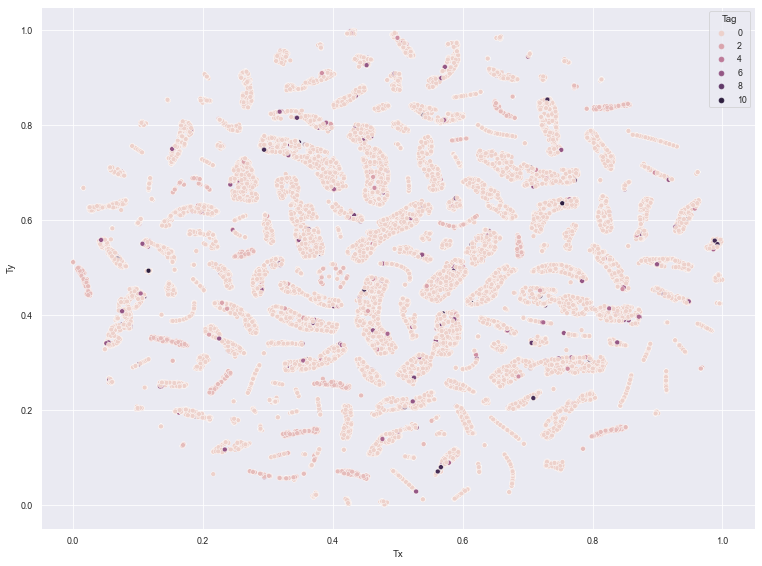

In [20]:
sns.scatterplot(x="Tx",y="Ty",hue="Tag",data=df_tsne)
plt.show()

# Train Random Forests:

## All Data:

In [100]:
# Hyperparameters:

testSize = 0.5
n_estimators = 100
max_depth = 10
tagNames = ['Artifacts', 'badsequence', 'Field_artefacts', 'highiron-lowt1', 'lookuptable-rip', 'm50pcfail', 'Other_Unlisted', 'pdff35', 'Rainbow', 'Segmentation_fail', 'Wrong_location', 'zeroct1']
numAvgs = np.arange(0,20,1)


In [101]:
x0, y0 = ownDataset

metricsDict = {}
clfDict = {}

topAUC = {}
avgAUC = {}
featureImportanceDict = {}

for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}
    avgAUC[name] = []
    featureImportanceDict[name] = {"Feature Names":[],"Feature Importance":[]}

for nAv in numAvgs:
    for idx,name in enumerate(tagNames):
        sys.stdout.write("\r[{}/{}]".format(nAv*len(tagNames)+idx,numAvgs.shape[0]*len(tagNames)))
        clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,verbose=False,n_jobs=-1)

        y = y0[:,idx]
        X = x0[:,:]

        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=testSize,random_state=42)

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        probs = clf.predict_proba(X_test)

        fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
        auc_score = roc_auc_score(y_test,probs[:,1])

        avgAUC[name].append(auc_score)
        featureImportanceDict[name]["Feature Names"].extend(featureNames)
        featureImportanceDict[name]["Feature Importance"].extend(clf.feature_importances_)

        if topAUC[name] < auc_score:
            topAUC[name] = auc_score
            clfDict[name] = clf

            metricsDict[name]["AUC"] = auc_score
            metricsDict[name]["FPR"] = fpr
            metricsDict[name]["TPR"] = tpr

[239/240]

In [102]:
# Format for Seaborn

modelsArr = []
fprArr = []
tprArr = []

for name in tagNames:
    auc_score = metricsDict[name]["AUC"]
    fpr = metricsDict[name]["FPR"]
    tpr = metricsDict[name]["TPR"]

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})
df2 = pandas.DataFrame(avgAUC)
print(df2.describe())

print("#"*50)

tempDict = {"Name":tagNames,"Max AUC":[metricsDict[name]["AUC"] for name in tagNames],"Avg AUC":[np.mean(avgAUC[name]) for name in tagNames]}

df3 = pandas.DataFrame(tempDict)
print(df3)

       Artifacts  badsequence  Field_artefacts  highiron-lowt1  \
count  20.000000    20.000000        20.000000       20.000000   
mean    0.734847     0.999602         0.849442        0.810255   
std     0.008681     0.000033         0.006088        0.015438   
min     0.711999     0.999560         0.838320        0.771206   
25%     0.731533     0.999581         0.843503        0.801112   
50%     0.734576     0.999594         0.850602        0.812872   
75%     0.737842     0.999619         0.853987        0.817391   
max     0.749696     0.999667         0.857921        0.839214   

       lookuptable-rip  m50pcfail  Other_Unlisted     pdff35    Rainbow  \
count        20.000000  20.000000       20.000000  20.000000  20.000000   
mean          0.788651   0.922441        0.902131   0.817621   0.912226   
std           0.020796   0.003256        0.004942   0.007340   0.002947   
min           0.729242   0.917014        0.890393   0.804121   0.907263   
25%           0.785758   0.919

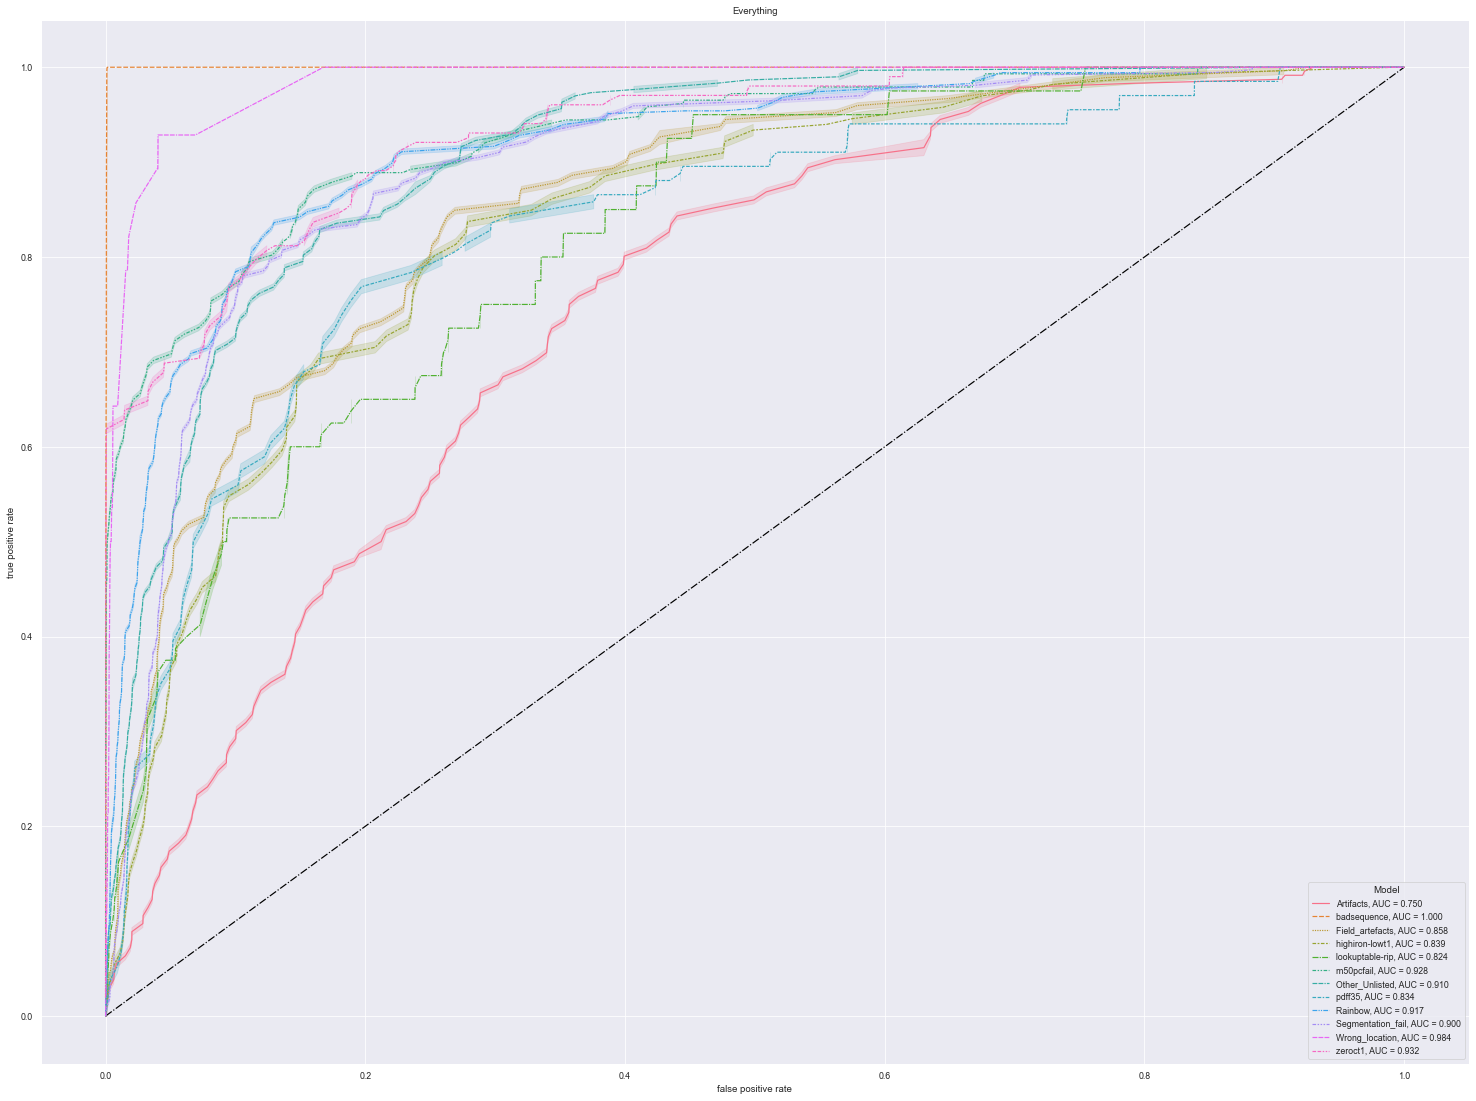

In [103]:
# Plot the ROC curves for each Class (One Vs Rest)

plt.figure()
plt.title("Everything")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

In [104]:
# Save Models
saveDir = "./models/Random Forests/All_Meta/"

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    pickle.dump(clfDict[name], open(os.path.join(saveDir,name,"classifier.sav"),'wb'))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

### Feature Importance

In [105]:
plt.rcParams['figure.figsize'] = [6.4*4, 4.8*4]

figDir = "./featureImportance/All_Data/"

arr = np.array(np.arange(len(featureNames)))
arr = np.array_split(arr,20)
featureNames = np.array(featureNames)
cntArr = np.arange(0,len(featureImportanceDict[tagNames[0]]["Feature Names"]),len(featureNames))

for idx,name in enumerate(tagNames):
    
    subFigDir = "{}{}/".format(figDir,name)
    if not os.path.isdir(subFigDir):
        os.makedirs(subFigDir)

    featureImportanceDict[name]["Feature Names"] = np.array(featureImportanceDict[name]["Feature Names"])
    featureImportanceDict[name]["Feature Importance"] = np.array(featureImportanceDict[name]["Feature Importance"])

    maxVal = np.max(featureImportanceDict[name]["Feature Importance"])

    for subArr in arr:

        featuresPlot = {"Feature Names":[],"Feature Importance":[]}
        for cntVal in cntArr:
            featuresPlot["Feature Names"].extend(featureImportanceDict[name]["Feature Names"][subArr+cntVal])
            featuresPlot["Feature Importance"].extend(featureImportanceDict[name]["Feature Importance"][subArr+cntVal])

        featuresPlot["Feature Names"] = np.array(featuresPlot["Feature Names"])
        featuresPlot["Feature Importance"] = np.array(featuresPlot["Feature Importance"])

        df_fImp = pandas.DataFrame(featuresPlot)

        sns.boxplot(y="Feature Names",x="Feature Importance",data=df_fImp)
        plt.xlim([0,maxVal])

        plt.savefig("{}{}_{}".format(subFigDir,subArr[0],subArr[-1]))
        plt.close("all")

In [106]:
for idx,name in enumerate(tagNames):
    
    subFigDir = "{}{}/".format(figDir,name)
    if not os.path.isdir(subFigDir):
        os.makedirs(subFigDir)

    clf = clfDict[name]
    arr = np.argsort(clf.feature_importances_)

    featuresPlot = {"Feature Names":[],"Feature Importance":[]}
    for cntVal in cntArr:
        featuresPlot["Feature Names"].extend(featureImportanceDict[name]["Feature Names"][arr[-30:]+cntVal])
        featuresPlot["Feature Importance"].extend(featureImportanceDict[name]["Feature Importance"][arr[-30:]+cntVal])

    featuresPlot["Feature Names"] = np.array(featuresPlot["Feature Names"])
    featuresPlot["Feature Importance"] = np.array(featuresPlot["Feature Importance"])

    df_fImp = pandas.DataFrame(featuresPlot)

    sns.boxplot(y="Feature Names",x="Feature Importance",data=df_fImp)

    plt.savefig("{}Top30".format(subFigDir))
    plt.close("all")

## Meta + Bboxes:

In [107]:
x0, y0 = ownDataset

metricsDict = {}
clfDict = {}

topAUC = {}
avgAUC = {}
featureImportanceDict = {}

for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}
    avgAUC[name] = []
    featureImportanceDict[name] = {"Feature Names":[],"Feature Importance":[]}

for nAv in numAvgs:
    for idx,name in enumerate(tagNames):
        sys.stdout.write("\r[{}/{}]".format(nAv*len(tagNames)+idx,numAvgs.shape[0]*len(tagNames)))
        clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,verbose=False,n_jobs=-1)

        y = y0[:,idx]
        X = x0[:,:-errLength]

        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=testSize,random_state=42)

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        probs = clf.predict_proba(X_test)

        fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
        auc_score = roc_auc_score(y_test,probs[:,1])

        avgAUC[name].append(auc_score)
        featureImportanceDict[name]["Feature Names"].extend(featureNames[:-errLength])
        featureImportanceDict[name]["Feature Importance"].extend(clf.feature_importances_)

        if topAUC[name] < auc_score:
            topAUC[name] = auc_score
            clfDict[name] = clf

            metricsDict[name]["AUC"] = auc_score
            metricsDict[name]["FPR"] = fpr
            metricsDict[name]["TPR"] = tpr

[239/240]

In [108]:
# Format for Seaborn

modelsArr = []
fprArr = []
tprArr = []

for name in tagNames:
    auc_score = metricsDict[name]["AUC"]
    fpr = metricsDict[name]["FPR"]
    tpr = metricsDict[name]["TPR"]

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})
df2 = pandas.DataFrame(avgAUC)
print(df2.describe())

print("#"*50)

tempDict = {"Name":tagNames,"Max AUC":[metricsDict[name]["AUC"] for name in tagNames],"Avg AUC":[np.mean(avgAUC[name]) for name in tagNames]}

df3 = pandas.DataFrame(tempDict)
print(df3)

       Artifacts  badsequence  Field_artefacts  highiron-lowt1  \
count  20.000000    20.000000        20.000000       20.000000   
mean    0.608267     0.999680         0.803046        0.540769   
std     0.011300     0.000034         0.005262        0.020513   
min     0.591531     0.999620         0.791193        0.512980   
25%     0.599975     0.999654         0.801359        0.519853   
50%     0.607211     0.999674         0.803952        0.544384   
75%     0.614484     0.999703         0.805461        0.554496   
max     0.635151     0.999741         0.812046        0.580201   

       lookuptable-rip  m50pcfail  Other_Unlisted     pdff35    Rainbow  \
count        20.000000  20.000000       20.000000  20.000000  20.000000   
mean          0.722446   0.718894        0.663881   0.734253   0.880277   
std           0.018960   0.009814        0.010934   0.012569   0.004980   
min           0.673203   0.700426        0.642372   0.713249   0.871034   
25%           0.713801   0.712

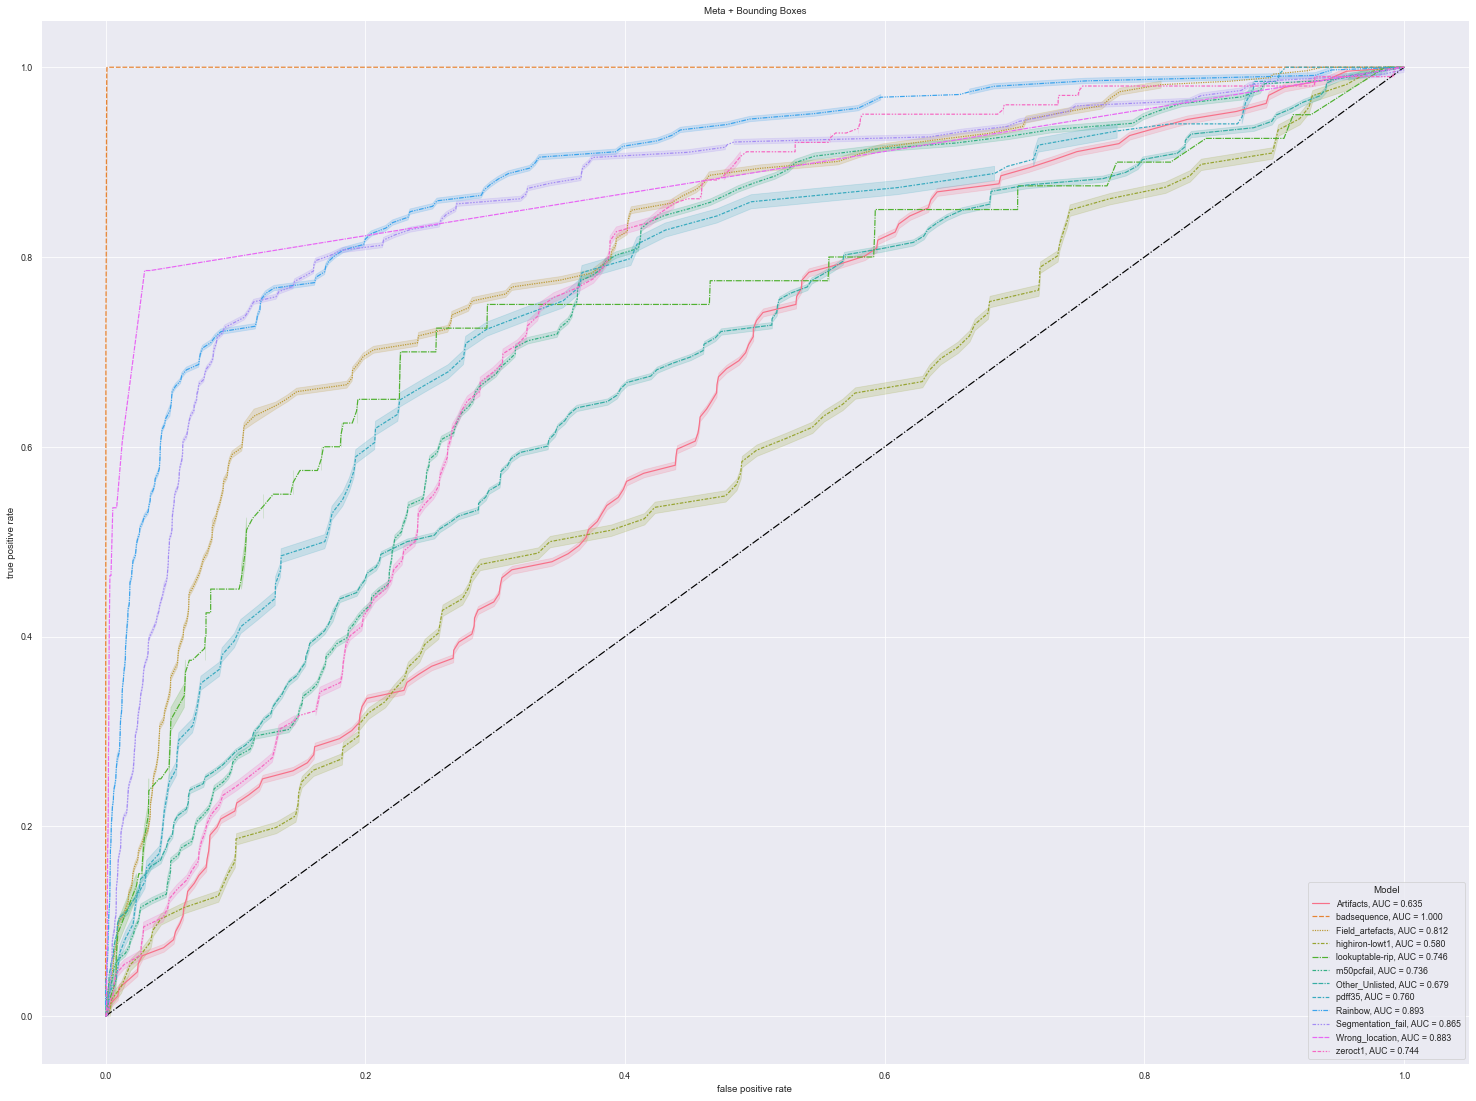

In [109]:
# Plot the ROC curves for each Class (One Vs Rest)

plt.figure()
plt.title("Meta + Bounding Boxes")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

In [110]:
# Save Models
saveDir = "./models/Random Forests/Meta_BBoxes/"

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    pickle.dump(clfDict[name], open(os.path.join(saveDir,name,"classifier.sav"),'wb'))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

### Feature Importance

In [114]:
plt.rcParams['figure.figsize'] = [6.4*4, 4.8*4]

figDir = "./featureImportance/Meta_BBoxes/"

arr = np.array(np.arange(len(featureNames[:-errLength])))
arr = np.array_split(arr,20)
cntArr = np.arange(0,len(featureImportanceDict[tagNames[0]]["Feature Names"]),len(featureNames[:-errLength]))

for idx,name in enumerate(tagNames):
    
    subFigDir = "{}{}/".format(figDir,name)
    if not os.path.isdir(subFigDir):
        os.makedirs(subFigDir)

    featureImportanceDict[name]["Feature Names"] = np.array(featureImportanceDict[name]["Feature Names"])
    featureImportanceDict[name]["Feature Importance"] = np.array(featureImportanceDict[name]["Feature Importance"])

    maxVal = np.max(featureImportanceDict[name]["Feature Importance"])

    for subArr in arr:

        featuresPlot = {"Feature Names":[],"Feature Importance":[]}
        for cntVal in cntArr:
            featuresPlot["Feature Names"].extend(featureImportanceDict[name]["Feature Names"][subArr+cntVal])
            featuresPlot["Feature Importance"].extend(featureImportanceDict[name]["Feature Importance"][subArr+cntVal])

        featuresPlot["Feature Names"] = np.array(featuresPlot["Feature Names"])
        featuresPlot["Feature Importance"] = np.array(featuresPlot["Feature Importance"])

        df_fImp = pandas.DataFrame(featuresPlot)

        sns.boxplot(y="Feature Names",x="Feature Importance",data=df_fImp)
        plt.xlim([0,maxVal])

        plt.savefig("{}{}_{}".format(subFigDir,subArr[0],subArr[-1]))
        plt.close("all")

In [115]:
for idx,name in enumerate(tagNames):
    
    subFigDir = "{}{}/".format(figDir,name)
    if not os.path.isdir(subFigDir):
        os.makedirs(subFigDir)

    clf = clfDict[name]
    arr = np.argsort(clf.feature_importances_)

    featuresPlot = {"Feature Names":[],"Feature Importance":[]}
    for cntVal in cntArr:
        featuresPlot["Feature Names"].extend(featureImportanceDict[name]["Feature Names"][arr[-30:]+cntVal])
        featuresPlot["Feature Importance"].extend(featureImportanceDict[name]["Feature Importance"][arr[-30:]+cntVal])

    featuresPlot["Feature Names"] = np.array(featuresPlot["Feature Names"])
    featuresPlot["Feature Importance"] = np.array(featuresPlot["Feature Importance"])

    df_fImp = pandas.DataFrame(featuresPlot)

    sns.boxplot(y="Feature Names",x="Feature Importance",data=df_fImp)

    plt.savefig("{}Top30".format(subFigDir))
    plt.close("all")

## Meta Only:

In [116]:
x0, y0 = ownDataset

metricsDict = {}
clfDict = {}

topAUC = {}
avgAUC = {}
featureImportanceDict = {}

for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}
    avgAUC[name] = []
    featureImportanceDict[name] = {"Feature Names":[],"Feature Importance":[]}

for nAv in numAvgs:
    for idx,name in enumerate(tagNames):
        sys.stdout.write("\r[{}/{}]".format(nAv*len(tagNames)+idx,numAvgs.shape[0]*len(tagNames)))
        clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,verbose=False,n_jobs=-1)

        y = y0[:,idx]
        X = x0[:,:-(bBoxesLength+errLength)]

        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=testSize,random_state=42)

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        probs = clf.predict_proba(X_test)

        fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
        auc_score = roc_auc_score(y_test,probs[:,1])

        avgAUC[name].append(auc_score)
        featureImportanceDict[name]["Feature Names"].extend(featureNames[:-(bBoxesLength+errLength)])
        featureImportanceDict[name]["Feature Importance"].extend(clf.feature_importances_)

        if topAUC[name] < auc_score:
            topAUC[name] = auc_score
            clfDict[name] = clf

            metricsDict[name]["AUC"] = auc_score
            metricsDict[name]["FPR"] = fpr
            metricsDict[name]["TPR"] = tpr

[239/240]

In [117]:
# Format for Seaborn

modelsArr = []
fprArr = []
tprArr = []

for name in tagNames:
    auc_score = metricsDict[name]["AUC"]
    fpr = metricsDict[name]["FPR"]
    tpr = metricsDict[name]["TPR"]

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})
df2 = pandas.DataFrame(avgAUC)
print(df2.describe())

print("#"*50)

tempDict = {"Name":tagNames,"Max AUC":[metricsDict[name]["AUC"] for name in tagNames],"Avg AUC":[np.mean(avgAUC[name]) for name in tagNames]}

df3 = pandas.DataFrame(tempDict)
print(df3)

       Artifacts  badsequence  Field_artefacts  highiron-lowt1  \
count  20.000000    20.000000        20.000000       20.000000   
mean    0.597770     0.999690         0.798187        0.521585   
std     0.012533     0.000038         0.007768        0.023085   
min     0.576265     0.999597         0.783127        0.485679   
25%     0.591883     0.999669         0.794139        0.503413   
50%     0.594772     0.999686         0.799380        0.520585   
75%     0.602376     0.999716         0.803701        0.537669   
max     0.622382     0.999752         0.811549        0.567312   

       lookuptable-rip  m50pcfail  Other_Unlisted     pdff35    Rainbow  \
count        20.000000  20.000000       20.000000  20.000000  20.000000   
mean          0.707989   0.684362        0.620114   0.704908   0.869479   
std           0.019161   0.010418        0.009764   0.012755   0.005336   
min           0.679945   0.660828        0.598142   0.681180   0.858392   
25%           0.696601   0.679

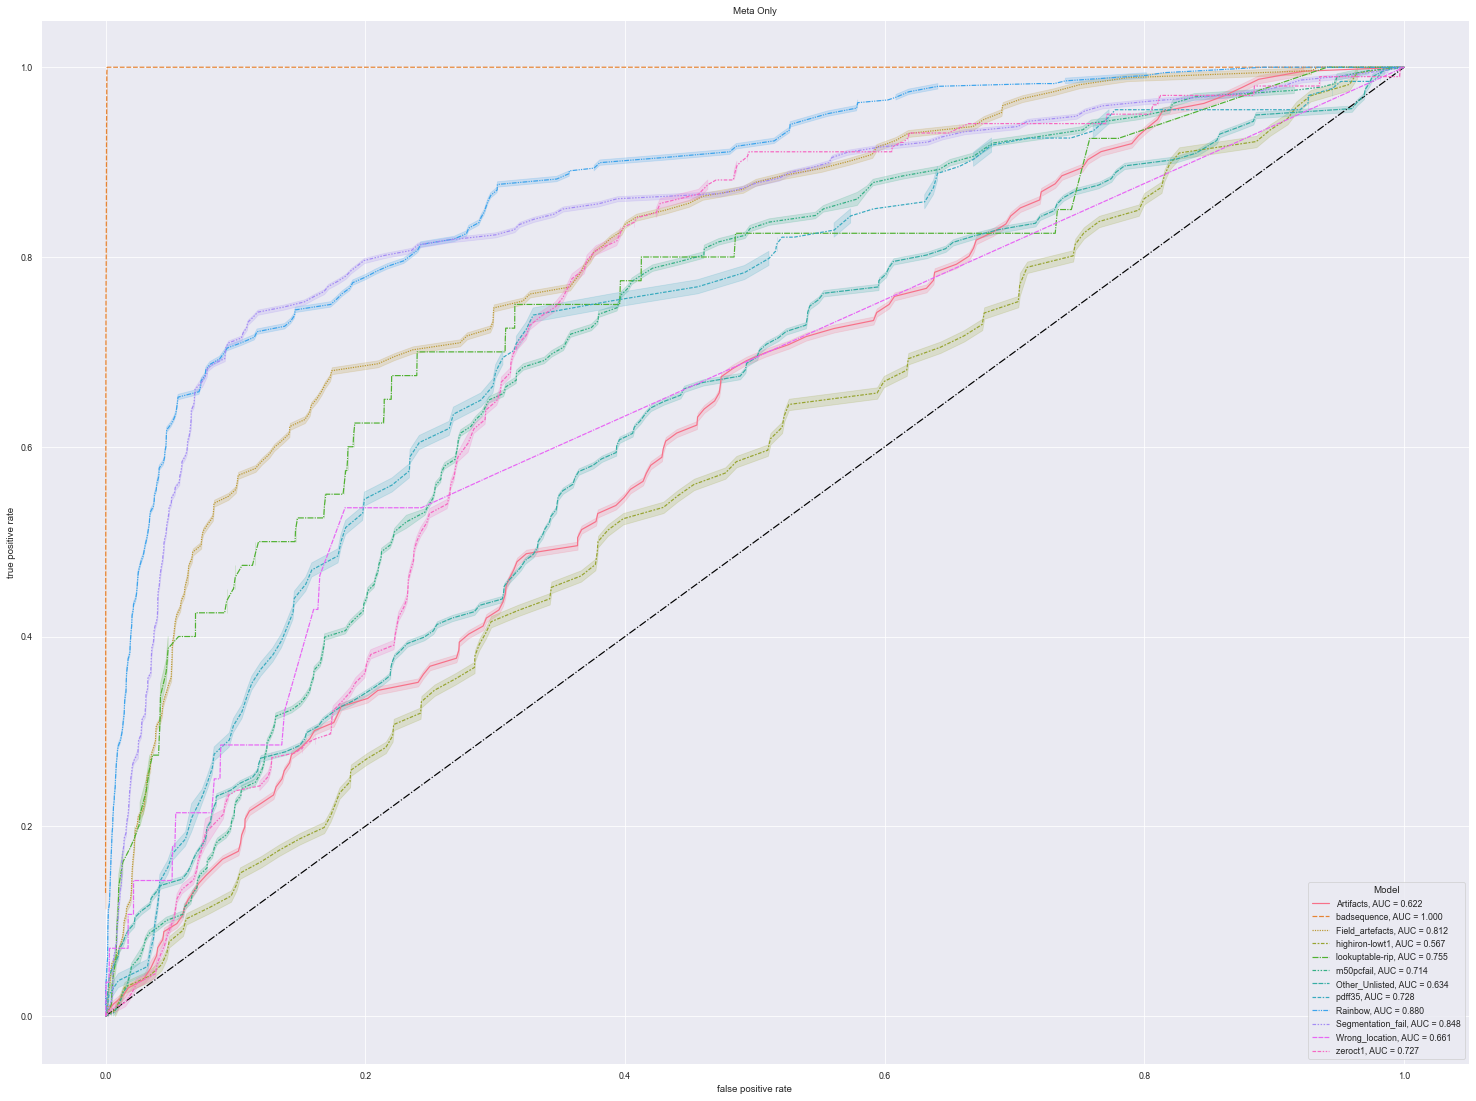

In [118]:
# Plot the ROC curves for each Class (One Vs Rest)

plt.figure()
plt.title("Meta Only")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

In [119]:
# Save Models
saveDir = "./models/Random Forests/Meta_Only/"

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    pickle.dump(clfDict[name], open(os.path.join(saveDir,name,"classifier.sav"),'wb'))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

### Feature Importance

In [120]:
plt.rcParams['figure.figsize'] = [6.4*4, 4.8*4]

figDir = "./featureImportance/Meta_Only/"

arr = np.array(np.arange(len(featureNames[:-(bBoxesLength+errLength)])))
arr = np.array_split(arr,20)
cntArr = np.arange(0,len(featureImportanceDict[tagNames[0]]["Feature Names"]),len(featureNames[:-(bBoxesLength+errLength)]))

for idx,name in enumerate(tagNames):
    
    subFigDir = "{}{}/".format(figDir,name)
    if not os.path.isdir(subFigDir):
        os.makedirs(subFigDir)

    featureImportanceDict[name]["Feature Names"] = np.array(featureImportanceDict[name]["Feature Names"])
    featureImportanceDict[name]["Feature Importance"] = np.array(featureImportanceDict[name]["Feature Importance"])

    maxVal = np.max(featureImportanceDict[name]["Feature Importance"])

    for subArr in arr:

        featuresPlot = {"Feature Names":[],"Feature Importance":[]}
        for cntVal in cntArr:
            featuresPlot["Feature Names"].extend(featureImportanceDict[name]["Feature Names"][subArr+cntVal])
            featuresPlot["Feature Importance"].extend(featureImportanceDict[name]["Feature Importance"][subArr+cntVal])

        featuresPlot["Feature Names"] = np.array(featuresPlot["Feature Names"])
        featuresPlot["Feature Importance"] = np.array(featuresPlot["Feature Importance"])

        df_fImp = pandas.DataFrame(featuresPlot)

        sns.boxplot(y="Feature Names",x="Feature Importance",data=df_fImp)
        plt.xlim([0,maxVal])

        plt.savefig("{}{}_{}".format(subFigDir,subArr[0],subArr[-1]))
        plt.close("all")

In [121]:
for idx,name in enumerate(tagNames):
    
    subFigDir = "{}{}/".format(figDir,name)
    if not os.path.isdir(subFigDir):
        os.makedirs(subFigDir)

    clf = clfDict[name]
    arr = np.argsort(clf.feature_importances_)

    featuresPlot = {"Feature Names":[],"Feature Importance":[]}
    for cntVal in cntArr:
        featuresPlot["Feature Names"].extend(featureImportanceDict[name]["Feature Names"][arr[-30:]+cntVal])
        featuresPlot["Feature Importance"].extend(featureImportanceDict[name]["Feature Importance"][arr[-30:]+cntVal])

    featuresPlot["Feature Names"] = np.array(featuresPlot["Feature Names"])
    featuresPlot["Feature Importance"] = np.array(featuresPlot["Feature Importance"])

    df_fImp = pandas.DataFrame(featuresPlot)

    sns.boxplot(y="Feature Names",x="Feature Importance",data=df_fImp)

    plt.savefig("{}Top30".format(subFigDir))
    plt.close("all")

## Error Only: 

In [122]:
x0, y0 = ownDataset

metricsDict = {}
clfDict = {}

topAUC = {}
avgAUC = {}
featureImportanceDict = {}

for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}
    avgAUC[name] = []
    featureImportanceDict[name] = {"Feature Names":[],"Feature Importance":[]}

for nAv in numAvgs:
    for idx,name in enumerate(tagNames):
        sys.stdout.write("\r[{}/{}]".format(nAv*len(tagNames)+idx,numAvgs.shape[0]*len(tagNames)))
        clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,verbose=False,n_jobs=-1)

        y = y0[:,idx]
        X = x0[:,-errLength:]

        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=testSize,random_state=42)

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        probs = clf.predict_proba(X_test)

        fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
        auc_score = roc_auc_score(y_test,probs[:,1])

        avgAUC[name].append(auc_score)
        featureImportanceDict[name]["Feature Names"].extend(featureNames[-errLength:])
        featureImportanceDict[name]["Feature Importance"].extend(clf.feature_importances_)

        if topAUC[name] < auc_score:
            topAUC[name] = auc_score
            clfDict[name] = clf

            metricsDict[name]["AUC"] = auc_score
            metricsDict[name]["FPR"] = fpr
            metricsDict[name]["TPR"] = tpr

[239/240]

In [123]:
# Format for Seaborn

modelsArr = []
fprArr = []
tprArr = []

for name in tagNames:
    auc_score = metricsDict[name]["AUC"]
    fpr = metricsDict[name]["FPR"]
    tpr = metricsDict[name]["TPR"]

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})
df2 = pandas.DataFrame(avgAUC)
print(df2.describe())

print("#"*50)

tempDict = {"Name":tagNames,"Max AUC":[metricsDict[name]["AUC"] for name in tagNames],"Avg AUC":[np.mean(avgAUC[name]) for name in tagNames]}

df3 = pandas.DataFrame(tempDict)
print(df3)

       Artifacts  badsequence  Field_artefacts  highiron-lowt1  \
count  20.000000    20.000000        20.000000       20.000000   
mean    0.735886     0.998336         0.850983        0.847940   
std     0.009657     0.000055         0.004618        0.010492   
min     0.717840     0.998228         0.844079        0.825550   
25%     0.729995     0.998306         0.847496        0.842086   
50%     0.734151     0.998339         0.850547        0.849386   
75%     0.741978     0.998361         0.853255        0.855292   
max     0.757502     0.998430         0.860696        0.862733   

       lookuptable-rip  m50pcfail  Other_Unlisted     pdff35    Rainbow  \
count        20.000000  20.000000       20.000000  20.000000  20.000000   
mean          0.813652   0.914832        0.907015   0.831044   0.902010   
std           0.026402   0.003636        0.004897   0.011667   0.004121   
min           0.767847   0.907255        0.896552   0.810714   0.894243   
25%           0.791891   0.912

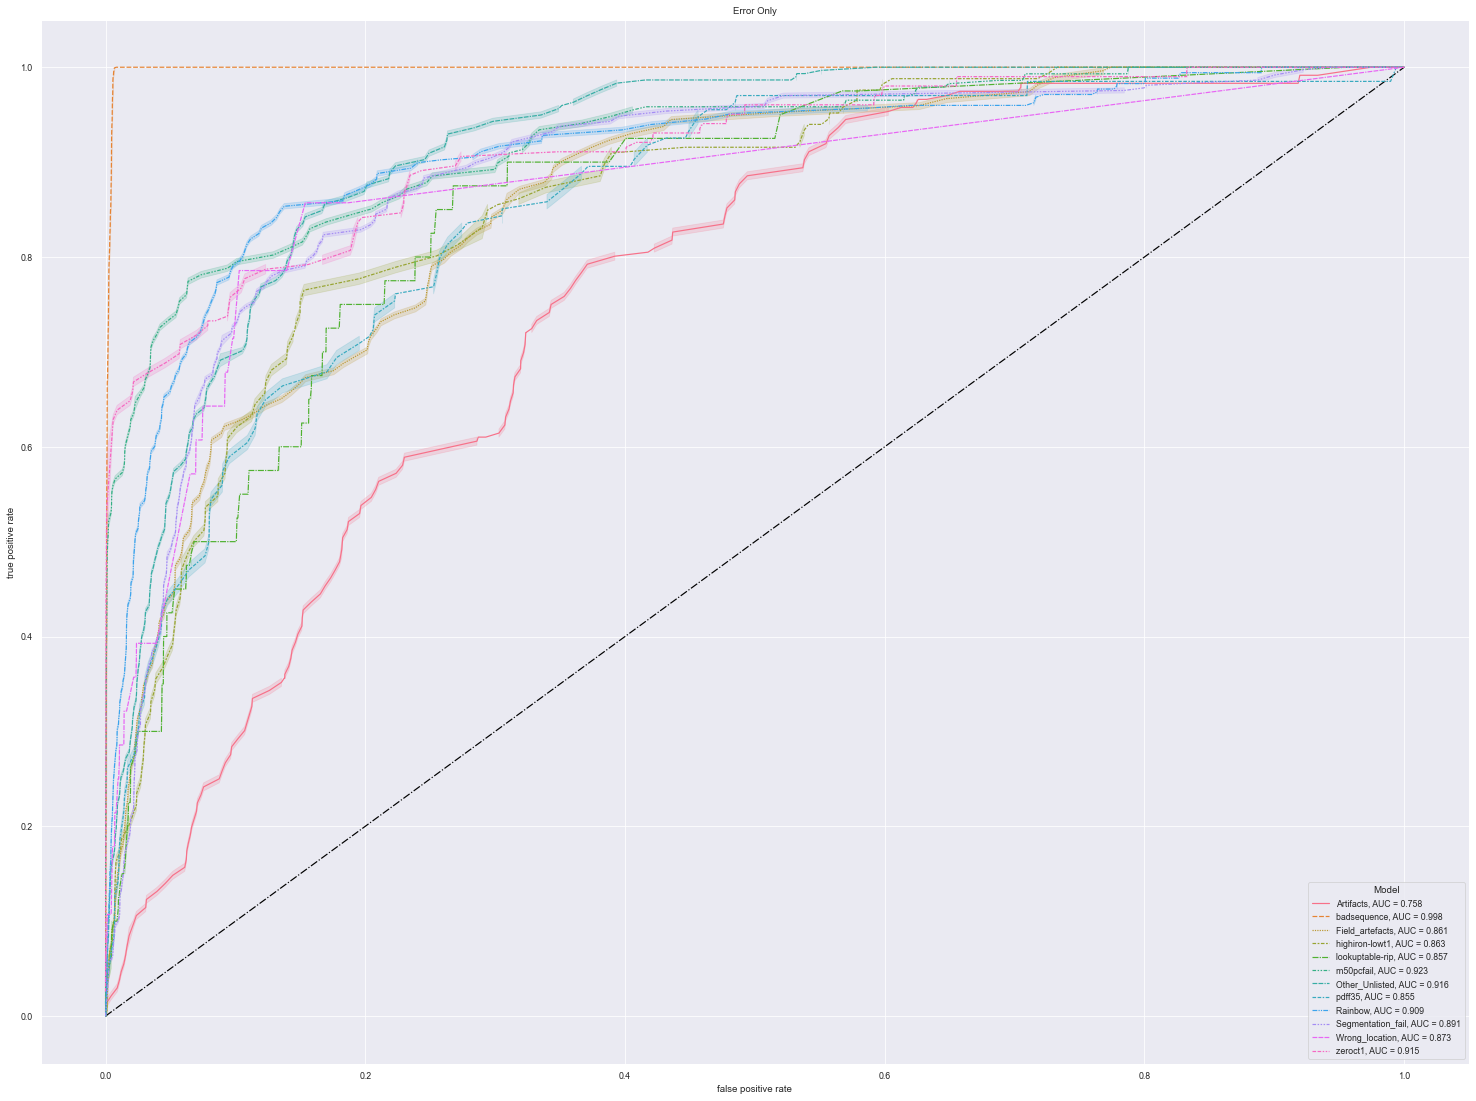

In [124]:
# Plot the ROC curves for each Class (One Vs Rest)

plt.figure()
plt.title("Error Only")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

In [125]:
# Save Models
saveDir = "./models/Random Forests/Error_Only/"

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    pickle.dump(clfDict[name], open(os.path.join(saveDir,name,"classifier.sav"),'wb'))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

### Feature Importance

In [126]:
plt.rcParams['figure.figsize'] = [6.4*4, 4.8*4]

figDir = "./featureImportance/Error_Only/"

arr = np.array(np.arange(len(featureNames[-errLength:])))
arr = np.array_split(arr,20)
cntArr = np.arange(0,len(featureImportanceDict[tagNames[0]]["Feature Names"]),len(featureNames[-errLength:]))

for idx,name in enumerate(tagNames):
    
    subFigDir = "{}{}/".format(figDir,name)
    if not os.path.isdir(subFigDir):
        os.makedirs(subFigDir)

    featureImportanceDict[name]["Feature Names"] = np.array(featureImportanceDict[name]["Feature Names"])
    featureImportanceDict[name]["Feature Importance"] = np.array(featureImportanceDict[name]["Feature Importance"])

    maxVal = np.max(featureImportanceDict[name]["Feature Importance"])

    for subArr in arr:

        featuresPlot = {"Feature Names":[],"Feature Importance":[]}
        for cntVal in cntArr:
            featuresPlot["Feature Names"].extend(featureImportanceDict[name]["Feature Names"][subArr+cntVal])
            featuresPlot["Feature Importance"].extend(featureImportanceDict[name]["Feature Importance"][subArr+cntVal])

        featuresPlot["Feature Names"] = np.array(featuresPlot["Feature Names"])
        featuresPlot["Feature Importance"] = np.array(featuresPlot["Feature Importance"])

        df_fImp = pandas.DataFrame(featuresPlot)

        sns.boxplot(y="Feature Names",x="Feature Importance",data=df_fImp)
        plt.xlim([0,maxVal])

        plt.savefig("{}{}_{}".format(subFigDir,subArr[0],subArr[-1]))
        plt.close("all")

In [127]:
for idx,name in enumerate(tagNames):
    
    subFigDir = "{}{}/".format(figDir,name)
    if not os.path.isdir(subFigDir):
        os.makedirs(subFigDir)

    clf = clfDict[name]
    arr = np.argsort(clf.feature_importances_)

    featuresPlot = {"Feature Names":[],"Feature Importance":[]}
    for cntVal in cntArr:
        featuresPlot["Feature Names"].extend(featureImportanceDict[name]["Feature Names"][arr[-30:]+cntVal])
        featuresPlot["Feature Importance"].extend(featureImportanceDict[name]["Feature Importance"][arr[-30:]+cntVal])

    featuresPlot["Feature Names"] = np.array(featuresPlot["Feature Names"])
    featuresPlot["Feature Importance"] = np.array(featuresPlot["Feature Importance"])

    df_fImp = pandas.DataFrame(featuresPlot)

    sns.boxplot(y="Feature Names",x="Feature Importance",data=df_fImp)

    plt.savefig("{}Top30".format(subFigDir))
    plt.close("all")

## Error + BBoxes:

In [128]:
x0, y0 = ownDataset

metricsDict = {}
clfDict = {}

topAUC = {}
avgAUC = {}
featureImportanceDict = {}

for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}
    avgAUC[name] = []
    featureImportanceDict[name] = {"Feature Names":[],"Feature Importance":[]}

for nAv in numAvgs:
    for idx,name in enumerate(tagNames):
        sys.stdout.write("\r[{}/{}]".format(nAv*len(tagNames)+idx,numAvgs.shape[0]*len(tagNames)))
        clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,verbose=False,n_jobs=-1)

        y = y0[:,idx]
        X = x0[:,-(bBoxesLength+errLength):]

        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=testSize,random_state=42)

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        probs = clf.predict_proba(X_test)

        fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
        auc_score = roc_auc_score(y_test,probs[:,1])

        avgAUC[name].append(auc_score)
        featureImportanceDict[name]["Feature Names"].extend(featureNames[-(bBoxesLength+errLength):])
        featureImportanceDict[name]["Feature Importance"].extend(clf.feature_importances_)

        if topAUC[name] < auc_score:
            topAUC[name] = auc_score
            clfDict[name] = clf

            metricsDict[name]["AUC"] = auc_score
            metricsDict[name]["FPR"] = fpr
            metricsDict[name]["TPR"] = tpr

[239/240]

In [129]:
# Format for Seaborn

modelsArr = []
fprArr = []
tprArr = []

for name in tagNames:
    auc_score = metricsDict[name]["AUC"]
    fpr = metricsDict[name]["FPR"]
    tpr = metricsDict[name]["TPR"]

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})
df2 = pandas.DataFrame(avgAUC)
print(df2.describe())

print("#"*50)

tempDict = {"Name":tagNames,"Max AUC":[metricsDict[name]["AUC"] for name in tagNames],"Avg AUC":[np.mean(avgAUC[name]) for name in tagNames]}

df3 = pandas.DataFrame(tempDict)
print(df3)

       Artifacts  badsequence  Field_artefacts  highiron-lowt1  \
count  20.000000    20.000000        20.000000       20.000000   
mean    0.740522     0.998829         0.849168        0.844311   
std     0.008685     0.000044         0.005348        0.013899   
min     0.724615     0.998765         0.838539        0.809759   
25%     0.734134     0.998799         0.844338        0.835231   
50%     0.741874     0.998819         0.850644        0.843382   
75%     0.746801     0.998852         0.851385        0.853973   
max     0.754355     0.998952         0.861076        0.864439   

       lookuptable-rip  m50pcfail  Other_Unlisted     pdff35    Rainbow  \
count        20.000000  20.000000       20.000000  20.000000  20.000000   
mean          0.803495   0.917206        0.909999   0.834870   0.906496   
std           0.023630   0.002974        0.003741   0.010829   0.004556   
min           0.735642   0.910200        0.901578   0.815259   0.894472   
25%           0.792329   0.915

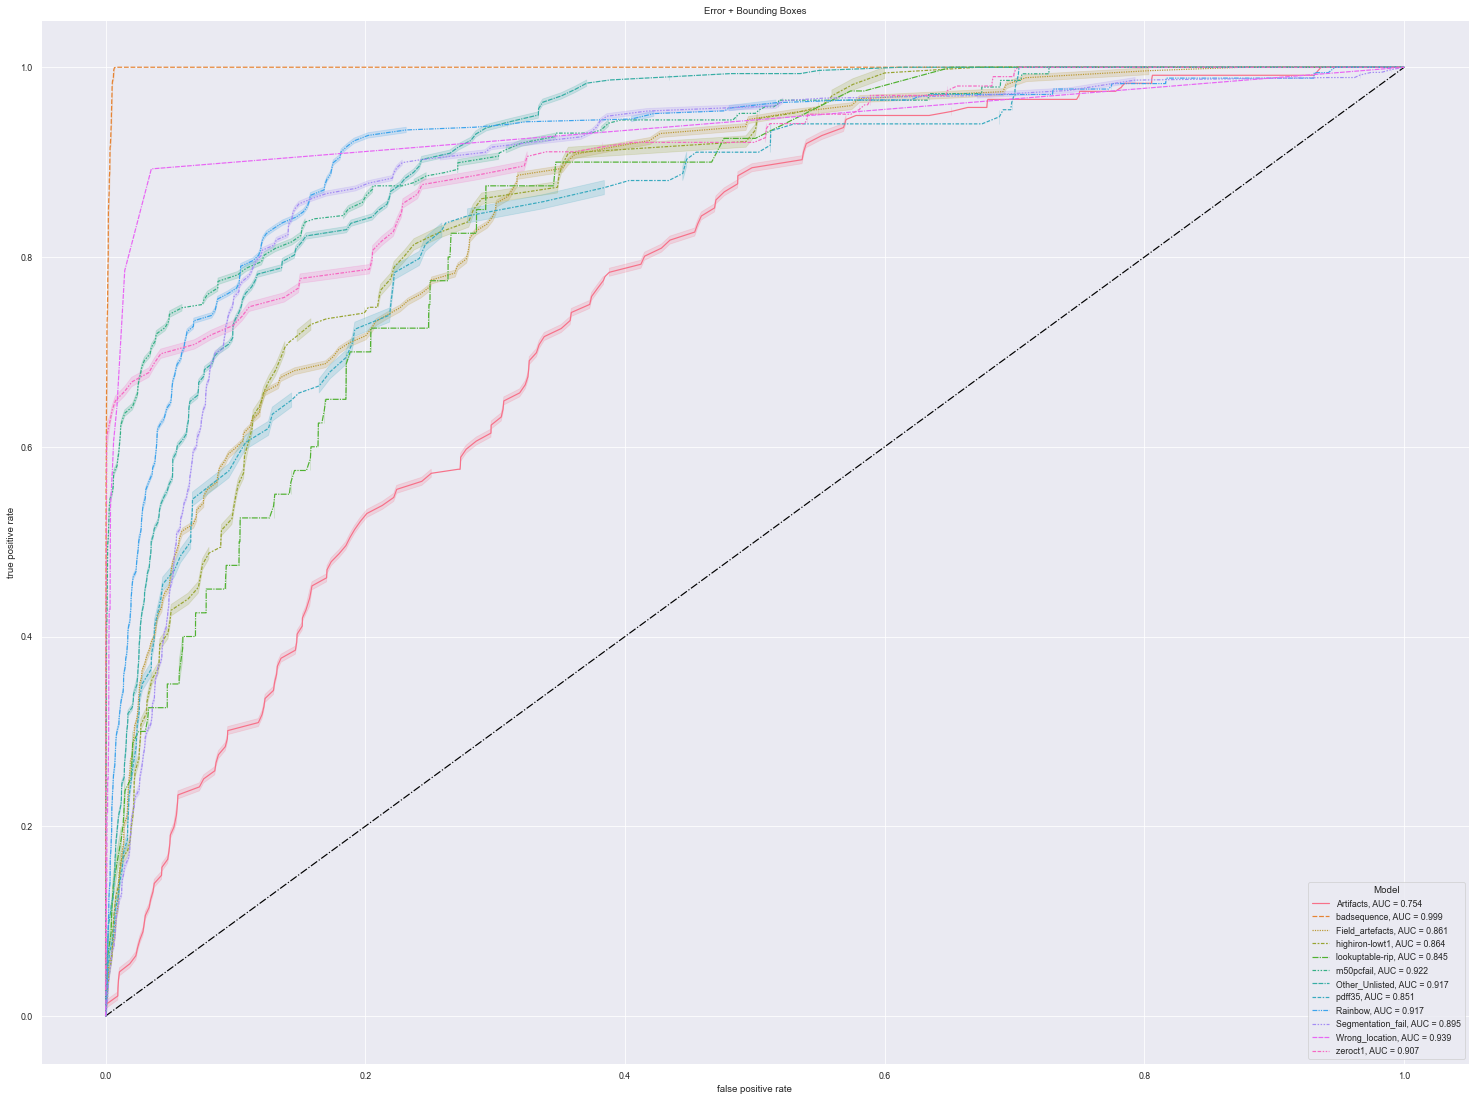

In [130]:
# Plot the ROC curves for each Class (One Vs Rest)

plt.figure()
plt.title("Error + Bounding Boxes")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

In [131]:
# Save Models
saveDir = "./models/Random Forests/Error_BBoxes/"

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    pickle.dump(clfDict[name], open(os.path.join(saveDir,name,"classifier.sav"),'wb'))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

### Feature Importance

In [132]:
plt.rcParams['figure.figsize'] = [6.4*4, 4.8*4]

figDir = "./featureImportance/Error_BBoxes/"

arr = np.array(np.arange(len(featureNames[-(bBoxesLength+errLength):])))
arr = np.array_split(arr,20)
cntArr = np.arange(0,len(featureImportanceDict[tagNames[0]]["Feature Names"]),len(featureNames[-(bBoxesLength+errLength):]))

for idx,name in enumerate(tagNames):
    
    subFigDir = "{}{}/".format(figDir,name)
    if not os.path.isdir(subFigDir):
        os.makedirs(subFigDir)

    featureImportanceDict[name]["Feature Names"] = np.array(featureImportanceDict[name]["Feature Names"])
    featureImportanceDict[name]["Feature Importance"] = np.array(featureImportanceDict[name]["Feature Importance"])

    maxVal = np.max(featureImportanceDict[name]["Feature Importance"])

    for subArr in arr:

        featuresPlot = {"Feature Names":[],"Feature Importance":[]}
        for cntVal in cntArr:
            featuresPlot["Feature Names"].extend(featureImportanceDict[name]["Feature Names"][subArr+cntVal])
            featuresPlot["Feature Importance"].extend(featureImportanceDict[name]["Feature Importance"][subArr+cntVal])

        featuresPlot["Feature Names"] = np.array(featuresPlot["Feature Names"])
        featuresPlot["Feature Importance"] = np.array(featuresPlot["Feature Importance"])

        df_fImp = pandas.DataFrame(featuresPlot)

        sns.boxplot(y="Feature Names",x="Feature Importance",data=df_fImp)
        plt.xlim([0,maxVal])

        plt.savefig("{}{}_{}".format(subFigDir,subArr[0],subArr[-1]))
        plt.close("all")

In [133]:
for idx,name in enumerate(tagNames):
    
    subFigDir = "{}{}/".format(figDir,name)
    if not os.path.isdir(subFigDir):
        os.makedirs(subFigDir)

    clf = clfDict[name]
    arr = np.argsort(clf.feature_importances_)

    featuresPlot = {"Feature Names":[],"Feature Importance":[]}
    for cntVal in cntArr:
        featuresPlot["Feature Names"].extend(featureImportanceDict[name]["Feature Names"][arr[-30:]+cntVal])
        featuresPlot["Feature Importance"].extend(featureImportanceDict[name]["Feature Importance"][arr[-30:]+cntVal])

    featuresPlot["Feature Names"] = np.array(featuresPlot["Feature Names"])
    featuresPlot["Feature Importance"] = np.array(featuresPlot["Feature Importance"])

    df_fImp = pandas.DataFrame(featuresPlot)

    sns.boxplot(y="Feature Names",x="Feature Importance",data=df_fImp)

    plt.savefig("{}Top30".format(subFigDir))
    plt.close("all")

# AUC Comparisons:

                   All_Meta  Error_BBoxes  Error_Only  Meta_BBoxes  Meta_Only
Artifacts          0.734186      0.739642    0.737104     0.612133   0.594165
badsequence        0.999610      0.998763    0.998291     0.999667   0.999691
Field_artefacts    0.848246      0.850091    0.851315     0.806825   0.793817
highiron-lowt1     0.806442      0.845669    0.842191     0.538774   0.522356
lookuptable-rip    0.782288      0.806800    0.797491     0.711886   0.716926
m50pcfail          0.922317      0.917283    0.914753     0.714100   0.686130
Other_Unlisted     0.901069      0.910511    0.904812     0.657185   0.620587
pdff35             0.816923      0.834615    0.833491     0.738317   0.705642
Rainbow            0.910036      0.906017    0.900543     0.879956   0.869295
Segmentation_fail  0.890968      0.891053    0.886178     0.851418   0.832569
Wrong_location     0.914660      0.910666    0.794853     0.859817   0.585638
zeroct1            0.920859      0.898084    0.895755     0.7229

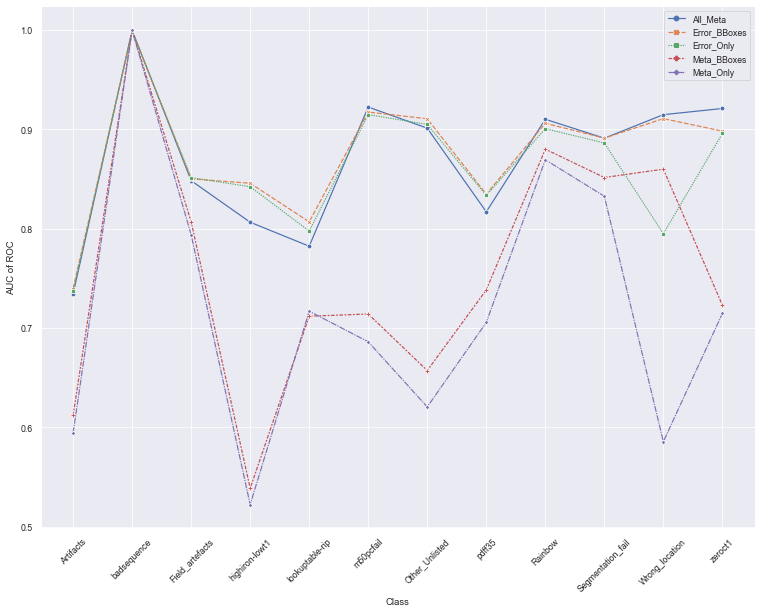

In [39]:
import seaborn as sns
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

loadDir = "./models/Random Forests/"

ignoreList = ["Float","Float_Categorical"]
rfList = [x for x in os.listdir(loadDir) if x not in ignoreList]

fullDict = {}
for fol in rfList:
    fullDict[fol] = {}
    with open(os.path.join(loadDir,fol,"metrics.json")) as f:
        metrics = json.load(f)
    for k1 in metrics.keys():
        avgAUC = []
        for k2 in metrics[k1].keys():
            avgAUC.append(metrics[k1][k2])
        fullDict[fol][k1] = np.mean(avgAUC)

df = pd.DataFrame(fullDict)
print(df)

plt.figure()
sns.lineplot(data=df,markers=True)
plt.xlabel("Class")
plt.ylabel("AUC of ROC")
plt.xticks(rotation=45)
plt.show()

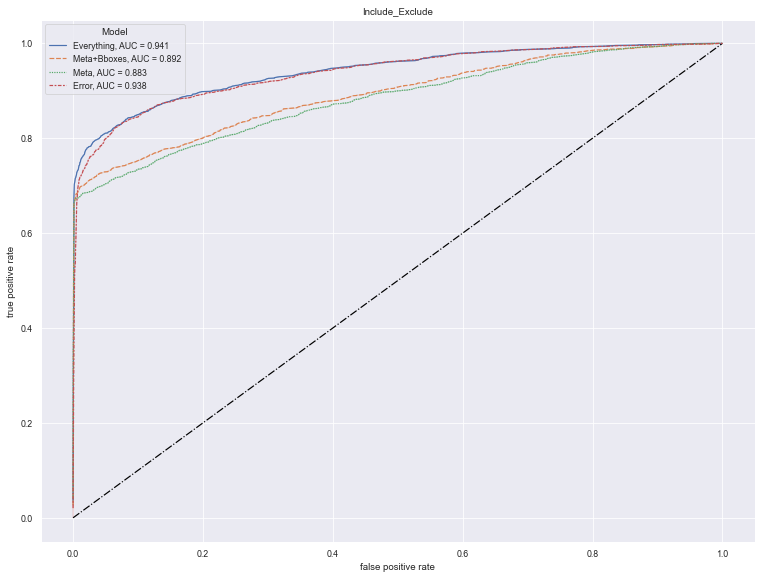

In [40]:
x0, y0 = ownDataset

newY = np.zeros(y0.shape[0])
for i in range(y0.shape[0]):
    if np.sum(y0[i,:]) >= 1:
        newY[i] = 1

y0 = newY

modelsArr = []
fprArr = []
tprArr = []
clfDict = {}

names = ["Everything","Meta+Bboxes","Meta","Error"]
features = [(0,-1),(0,-errFlat.shape[1]),(0,-(16+errFlat.shape[1])),(-errFlat.shape[1],-1)]

for name,(m,n) in zip(names,features):
    clf = RandomForestClassifier(n_estimators=100,max_depth=10,verbose=False,n_jobs=-1)

    y = y0
    if n == -1:
        X = x0[:,m:]
    else:
        X = x0[:,m:n]

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.4,random_state=42)

    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    probs = clf.predict_proba(X_test)

    fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
    auc_score = roc_auc_score(y_test,probs[:,1])

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    clfDict[name] = clf

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})

plt.figure()
plt.title("Include_Exclude")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

# Feature Importance:

In [41]:

featuresPlot = {}
for name in tagNames:
    featuresPlot[name] = []

for idx,name in enumerate(tagNames):
    print("#"*50)
    print(name)
    print("#"*50)

    clf = clfDict[name]
    instCnt = 0
    featCnt = -1
    for i,fImp in enumerate(clf.feature_importances_):
        if i % 7 == 0:
            instCnt = 0
            featCnt += 1
        if fImp > 0.005:
            featuresPlot[name].append((keysOI[featCnt],instTime[instCnt]))
            print("{},\t {}, \t\t\t {}".format(keysOI[featCnt],instTime[instCnt],fImp))
        instCnt += 1
    print("#"*50)


##################################################
Artifacts
##################################################


KeyError: 'Artifacts'

In [ ]:
name = "Segmentation_fail"

features = [x[0] for x in featuresPlot['Artifacts']]
features = list(set(features))

for topFeature in features:
    metaList = []
    instTimeList = []
    tagListStr = []
    for i,k in enumerate(metaDict.keys()):
        for inst in instTime:
            instTimeList.append(inst)
            metaList.append(metaDict[k][inst][topFeature])
            if k in tagDict.keys():
                issues = tagDict[k]
                if issues[idx] == 1:
                    tagListStr.append("Exclude")
                else:
                    tagListStr.append("Include")
            else:
                tagListStr.append("Include")

    d = {topFeature:metaList,"Instance":instTimeList,"Class":tagListStr}
    df = pandas.DataFrame(data=d)

    sns.violinplot(x="Instance",y=topFeature,hue="Class",split=False,data=df)
    plt.show()
